In [ ]:
!wget https://www.dropbox.com/s/r4jgo2sigegfnf1/model.weights
!wget https://www.dropbox.com/s/lveee68z05cpic4/classes.names
!wget https://www.dropbox.com/s/klvnh1tx6yypjnb/darknet-yolov3.cfg
!wget https://www.dropbox.com/s/3rcicy5fwio5tjm/requirements.txt

In [ ]:
!pip install -r requirements.txt

In [1]:
import easyocr
import cv2
from PIL import Image
import imutils
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid

## Detect plate with YOLO

### Initialize the parameters

In [2]:
confThreshold = 0.5  # Confidence threshold
nmsThreshold = 0.4  # Non-maximum suppression threshold

inpWidth = 416  # 608     # Width of network's input image
inpHeight = 416  # 608     # Height of network's input image

### Load names of classes

In [3]:
classesFile = "classes.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

### Give the configuration and weight files for the model and load the network using them.

In [6]:
modelConfiguration = "darknet-yolov3.cfg"
modelWeights = "model.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration,  modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [7]:
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [8]:
### Draw the predicted bounding box

In [9]:
def drawPred(img, classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    #    cv.rectangle(img, (left, top), (right, bottom), (255, 178, 50), 3)
    cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s: %s' % (classes[classId], label)

    # Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(img, (left, top - round(1.5*labelSize[1])), (left + round(
        1.5*labelSize[0]), top + baseLine), (255, 0, 255), cv2.FILLED)
    #cv.rectangle(img, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(img, label, (left, top),
               cv2.FONT_HERSHEY_SIMPLEX, 0.70, (255, 255, 255), 2)

### Remove the bounding boxes with low confidence using non-maxima suppression

In [10]:
def postprocess(img, outs):
    imgHeight = img.shape[0]
    imgWidth = img.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            # if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            # if scores[classId]>confThreshold:
            confidence = scores[classId]
            if detection[4] > confThreshold:
                print(detection[4], " - ", scores[classId],
                      " - th : ", confThreshold)
                print(detection)
            if confidence > confThreshold:
                center_x = int(detection[0] * imgWidth)
                center_y = int(detection[1] * imgHeight)
                width = int(detection[2] * imgWidth)
                height = int(detection[3] * imgHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    plates = []
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        plate = np.array(img[top:top+height, left:left+width])
        plates.append(plate)
        drawPred(img, classIds[i], confidences[i], left,
                 top, left + width, top + height)

    return plates

In [11]:
def detect_plate(img):
    # Create a 4D blob from a img.
    blob = cv2.dnn.blobFromImage(
        img, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    plates = postprocess(img, outs)

    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(img, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    return img , plates

### Reading The Image

In [12]:
# image_path = 'Car.jpg'
# base_image = cv2.imread(image_path)

In [15]:
from google.colab import files
from io import BytesIO

uploaded = files.upload()
im = Image.open(BytesIO(list(uploaded.values())[0]))
open_cv_image = np.array(im)
base_image = open_cv_image[:, :, ::-1].copy() 


Saving 20210108_143445.jpg to 20210108_143445.jpg


In [16]:
base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)  

## Show the image

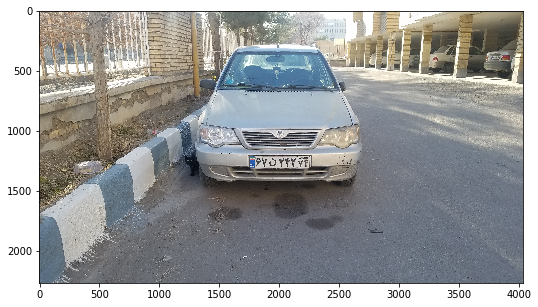

In [17]:
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.imshow(base_image, interpolation='nearest')

0.9998709  -  0.99975884  - th :  0.5
[0.49673864 0.5532026  0.12165324 0.04935604 0.9998709  0.99975884]
0.9911851  -  0.9903546  - th :  0.5
[0.5011805  0.5537234  0.1239885  0.04934064 0.9911851  0.9903546 ]


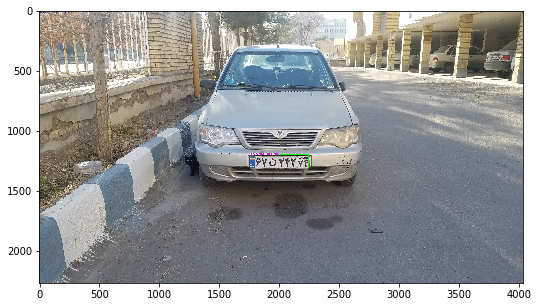

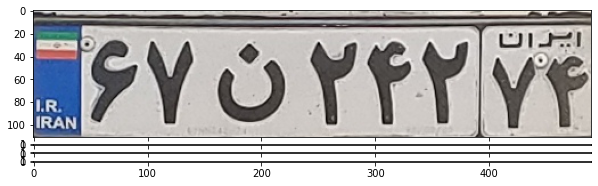

In [18]:
img_detected, plates = detect_plate(base_image)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(img_detected, interpolation='nearest')

if(len(plates)>0):
    fig = plt.figure(figsize=(10., 12.))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, len(plates)), axes_pad=0.1)
    for ax, im in zip(grid, plates):
        ax.imshow(im)

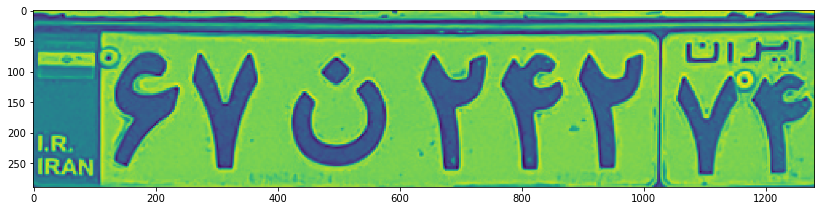

In [19]:
if(len(plates)>0):
    img = plates[0]

    img = imutils.resize(img, width=1280)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.imshow(gray, interpolation='nearest')
else:
    print("Plate Not Found!")

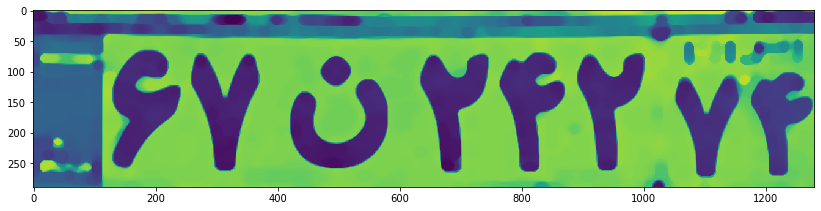

In [20]:

gray = cv2.fastNlMeansDenoisingColored(img,None,15,15,7,21)

gray =  cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 13, 15, 15)
kernel = np.ones((9,9),np.uint8)
edges = cv2.dilate(gray,kernel,iterations = 1)
kernel = np.ones((15,15),np.uint8)
gray = cv2.erode(edges,kernel,iterations = 1)

gray = cv2.medianBlur(gray,13)


fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(gray, interpolation='nearest')

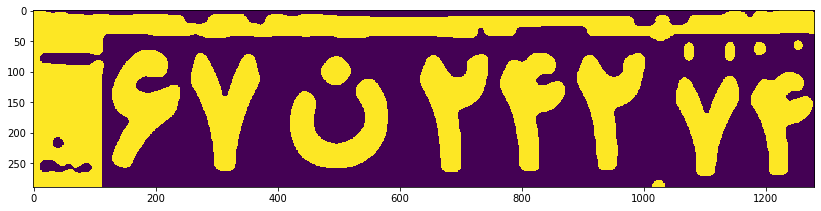

In [21]:
ret,thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(thresh, interpolation='nearest')

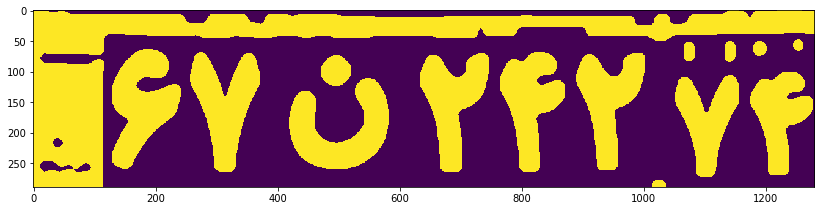

In [22]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilation = cv2.dilate(thresh, rect_kernel, iterations = 1)
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(dilation, interpolation='nearest')

In [ ]:
reader = easyocr.Reader(['fa']) # need to run only once to load model into memory


In [27]:
result = reader.readtext(gray)
result

[[[[111, 43], [1179, 43], [1179, 279], [111, 279]],
  '٢٤٢٧ ن٦٧',
  0.49687883809709954]]